## Week 4 Day 4 - preparing the big project!

# The Sidekick

It's time to introduce:

1. Structured Outputs
2. A multi-agent flow

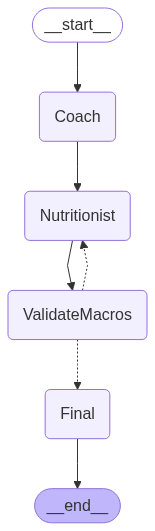

* Running on local URL:  http://127.0.0.1:7863


In [ ]:
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver
from typing import TypedDict
from langchain_core.runnables import RunnableLambda
from IPython.display import Image, display
import gradio as gr

# LLM compartido
llm = ChatOpenAI(model="gpt-4o")

# Estado
class State(TypedDict):
    task: str
    coach_response: str
    nutrition_response: str
    macro_validation: str
    final_summary: str

# Nodo: Coach
def coach_agent(state: State) -> State:
    prompt = f"""Sos un entrenador personal costarricense.
Analizá este input y generá recomendaciones físicas y de estilo de vida para que un nutricionista pueda crear un plan:

{state['task']}"""
    result = llm.invoke(prompt)
    state["coach_response"] = result.content
    return state

# Nodo: Nutricionista
def nutritionist_agent(state: State) -> State:
    prompt = f"""Sos un nutricionista clínico especializado en recomposición corporal.

Con base en estas recomendaciones del coach:
{state['coach_response']}

Generá un plan nutricional que incluya:
- Gramos por día de proteínas, carbohidratos y grasas
- Calorías totales
- Consideraciones (ayuno, alergias, etc.)
- Justificación técnica de las macros

Respondé en español, formato claro.
"""
    result = llm.invoke(prompt)
    state["nutrition_response"] = result.content
    return state

# Nodo: Validador de macros (directo al nutricionista)
def macro_validator(state: State) -> State:
    prompt = f"""Sos un experto en validación nutricional.

Revisá si este plan cumple con buenas prácticas:
{state['nutrition_response']}

Validá que:
- Las proporciones de macros sean coherentes
- Las calorías sean consistentes con los macros
- La justificación tenga sentido

Dale feedback técnico claro y recomendaciones si algo falla. Redactá en español.
"""
    result = llm.invoke(prompt)
    state["macro_validation"] = result.content
    return state

# Decisión condicional: ¿Necesita ajustes?
def should_regenerate_nutri(state: State) -> str:
    feedback = state["macro_validation"].lower()
    if "no coincide" in feedback or "error" in feedback or "corregir" in feedback or "ajuste" in feedback:
        return "Nutritionist"
    return "Final"

# Nodo: Resumen Final
def generate_summary(state: State) -> State:
    summary = f"""
📋 Evaluación Final del Plan Nutricional

✅ Plan del Nutricionista:
{state['nutrition_response']}

🔎 Validación de Macros:
{state['macro_validation']}

✨ Recordá: mejorar tu cuerpo toma tiempo, constancia y visión. 1% mejor cada día. 💪
"""
    result = llm.invoke(f"Convertí este contenido a Markdown claro para entregar como resumen final:\n{summary}")
    state["final_summary"] = result.content
    return state

# Armado del grafo
builder = StateGraph(State)

builder.add_node("Coach", RunnableLambda(coach_agent))
builder.add_node("Nutritionist", RunnableLambda(nutritionist_agent))
builder.add_node("ValidateMacros", RunnableLambda(macro_validator))
builder.add_node("Final", RunnableLambda(generate_summary))

builder.set_entry_point("Coach")
builder.add_edge("Coach", "Nutritionist")
builder.add_edge("Nutritionist", "ValidateMacros")

builder.add_conditional_edges("ValidateMacros", should_regenerate_nutri, {
    "Nutritionist": "Nutritionist",
    "Final": "Final"
})

builder.add_edge("Final", END)

graph = builder.compile(checkpointer=MemorySaver())
display(Image(graph.get_graph().draw_mermaid_png()))

# Interfaz Gradio
def run_pipeline(task):
    result = graph.invoke({"task": task}, config={"configurable": {"thread_id": "gradio-run"}})
    return (
        result["coach_response"],
        result["nutrition_response"],
        result["macro_validation"],
        result["final_summary"]
    )

with gr.Blocks() as demo:
    gr.Markdown("## 🧠 Nutrición Inteligente (Coach + Nutricionista + Validador)")
    task_input = gr.Textbox(label="📌 Ingresá tu InBody, metas, estilo de vida", lines=4)
    run_btn = gr.Button("💡 Generar Plan Nutricional")

    with gr.Row():
        with gr.Column():
            coach_out = gr.Textbox(label="🏋️ Coach")
            nutri_out = gr.Textbox(label="🥦 Nutricionista")
        with gr.Column():
            valid_out = gr.Textbox(label="🔎 Validación de Macros")
            final_out = gr.Textbox(label="✅ Resumen Final", lines=10)

    run_btn.click(fn=run_pipeline, inputs=[task_input], outputs=[
        coach_out, nutri_out, valid_out, final_out
    ])

demo.launch(share=True)
